# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website.

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

# Imports

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Read data

In [2]:
bike_rentals = pd.read_csv("hour.csv")

# FUNCTIONS

In [32]:
def distribution_plot(df, column, title, with_mean=True):
    
    plt.figure(figsize=(20,10))
    df[column].plot.hist()
    if with_mean:
        plt.axvline(df[column].mean(), color='black', label='mean')
    plt.title(title)
    plt.legend()
    
def corr_plot(df, column, title, rotation=90):
    plt.figure(figsize=(20,10))
    df.corr()[column].plot()
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.legend()
    
def hours_transformation(hour):
    """ 1 if the hour is from 6 to 12
        2 if the hour is from 12 to 18
        3 if the hour is from 18 to 24
        4 if the hour is from 0 to 6 """
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3
    
def value_counts_plot(df, column, title):
    plt.figure(figsize=(20,10))
    round(df[column].value_counts(dropna=False, normalize=True)*100, 2).plot(kind="bar")
    plt.title(title)
    plt.xlabel('%')
    plt.ylabel('Value')
    plt.legend()

# EDA

In [16]:
bike_rentals

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## TOTAL NUMBER OF BIKE RENTALS (CNT) DISTRIBUTION

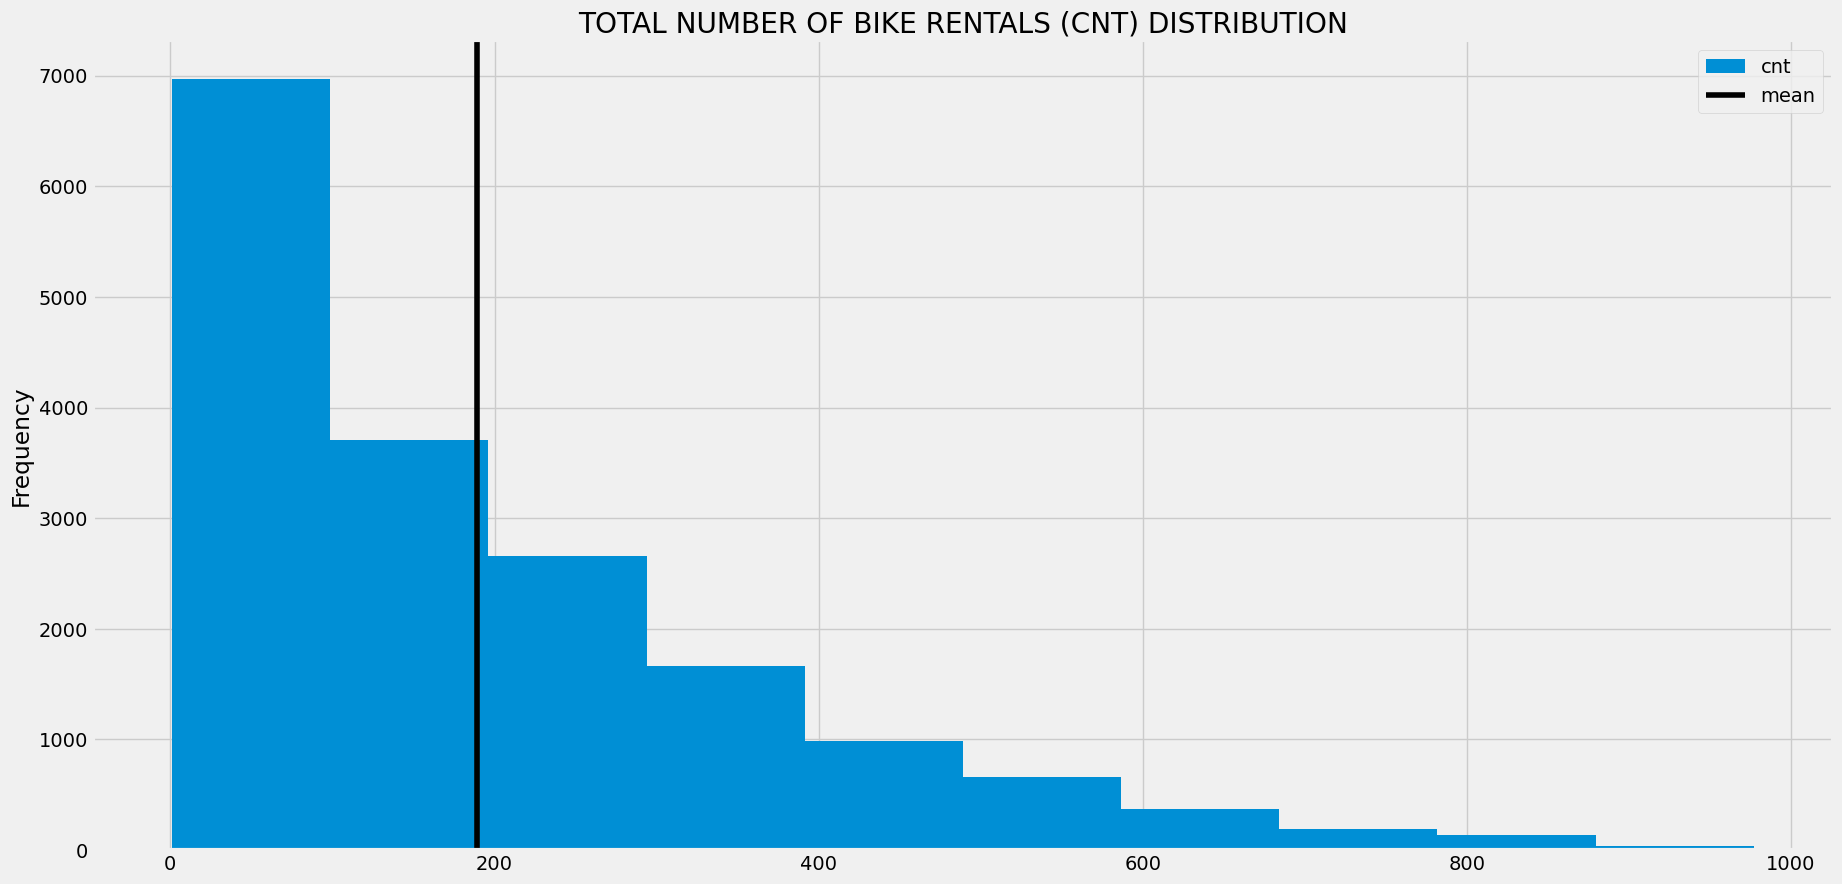

In [18]:
distribution_plot(bike_rentals, "cnt", "TOTAL NUMBER OF BIKE RENTALS (CNT) DISTRIBUTION", with_mean=True)

From the previous chart we observe that the average bike rentals is nearby 200.

## CNT CORRELATION

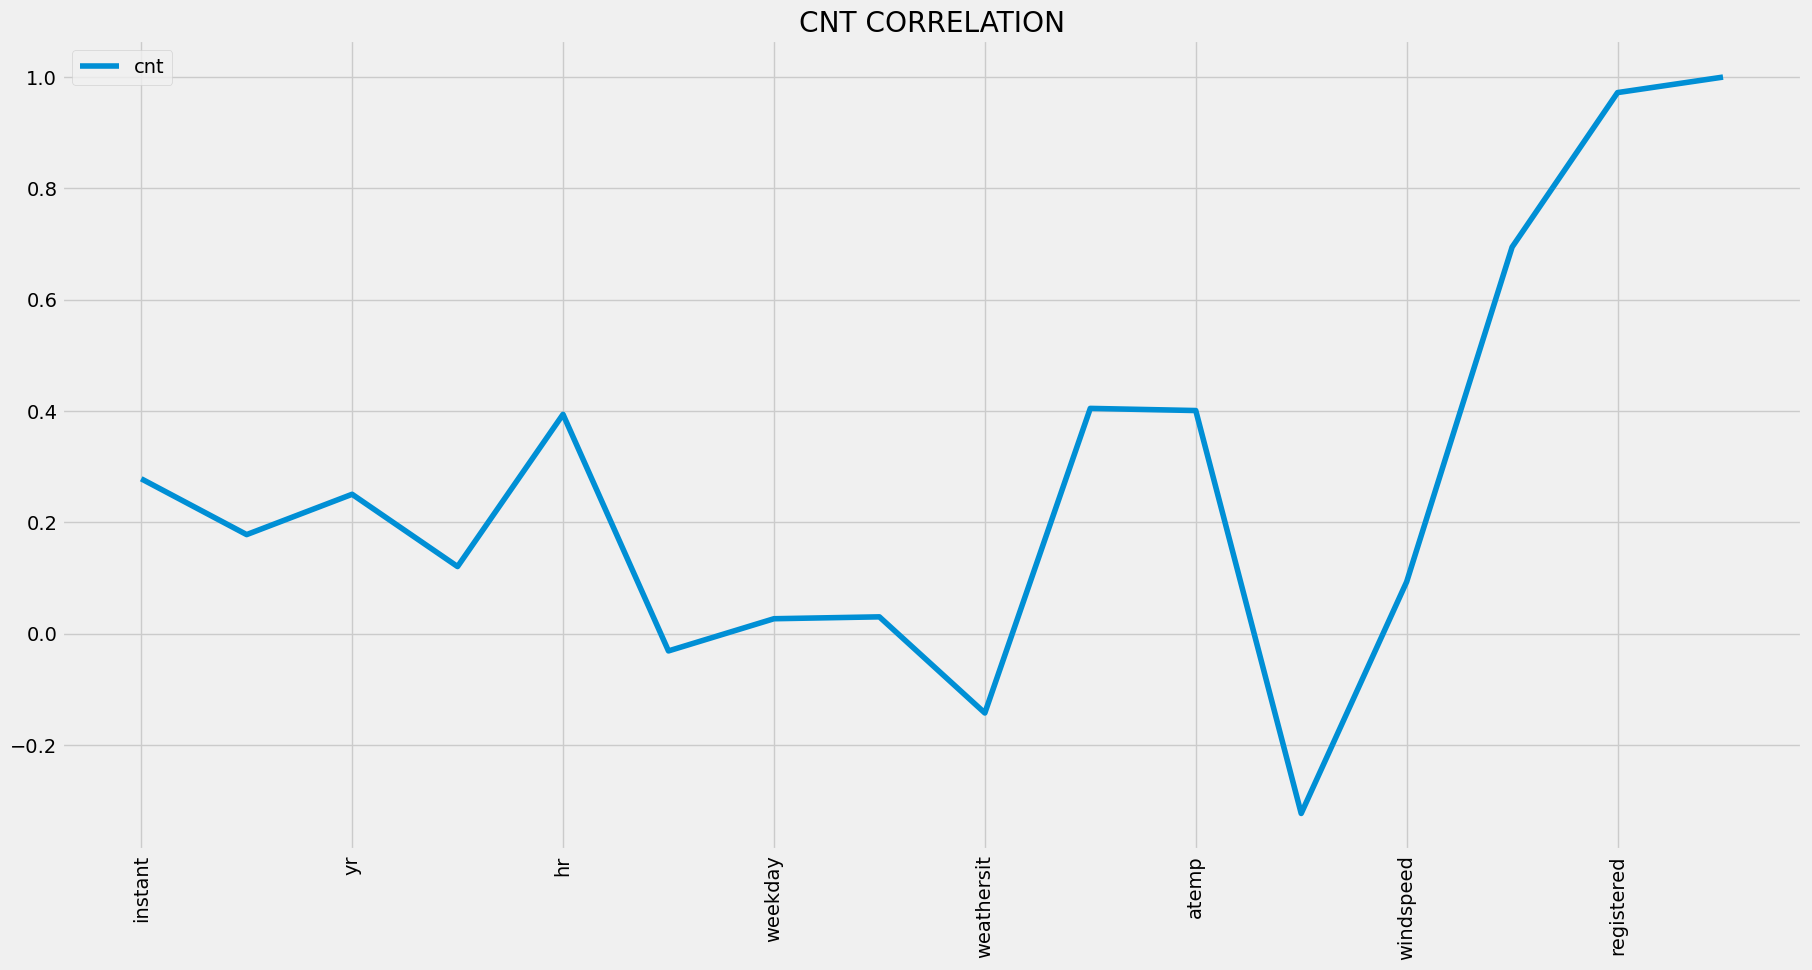

In [22]:
corr_plot(bike_rentals, "cnt", "CNT CORRELATION", rotation=90)

The most correlated columns to **CNT** are:
- Registered
- Windspeed
- Atemp
- Weathersit
- Hr

## TOTAL NUMBER OF BIKE RENTALS PER HOUR

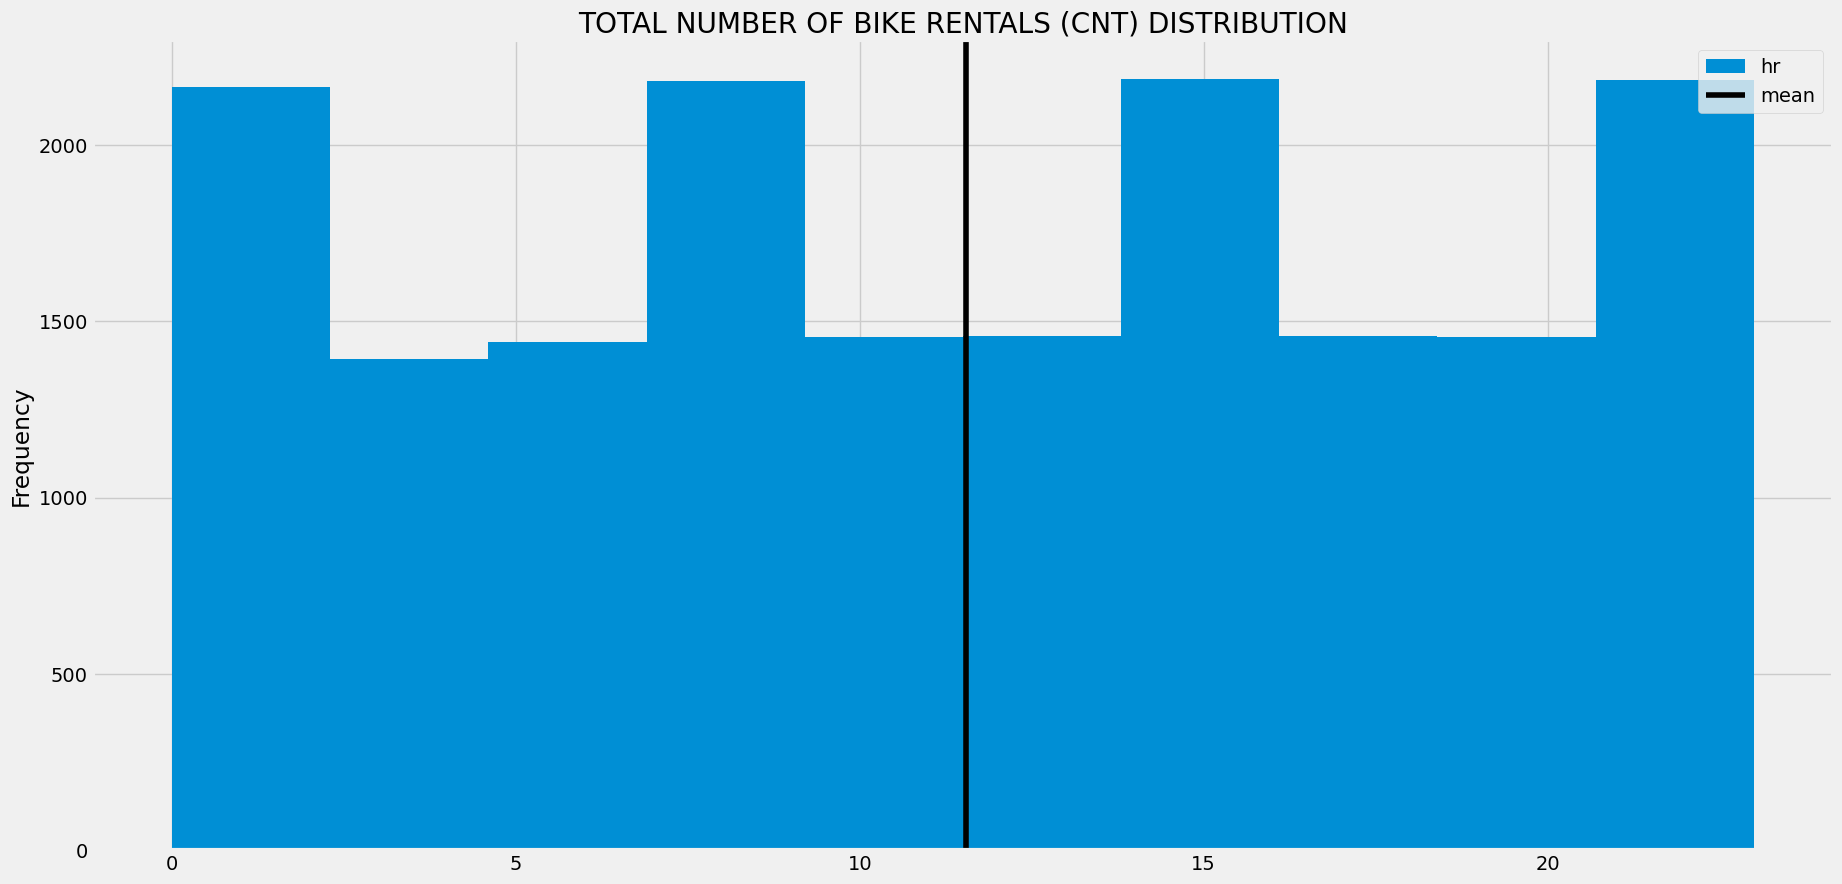

In [23]:
distribution_plot(bike_rentals, "hr", "TOTAL NUMBER OF BIKE RENTALS PER HOUR", with_mean=True)

# FEATURE ENGINEERING

## Time Label

The **hr** column in **bike_rentals** contains the hours during which bikes are rented, from **1** to **24**. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for **morning, afternoon, evening, and night**. This bundles similar times together, enabling the model to make better decisions.

In [27]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(hours_transformation)

In [28]:
bike_rentals["time_label"].value_counts(dropna=False)

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

### Time Label Value Counts

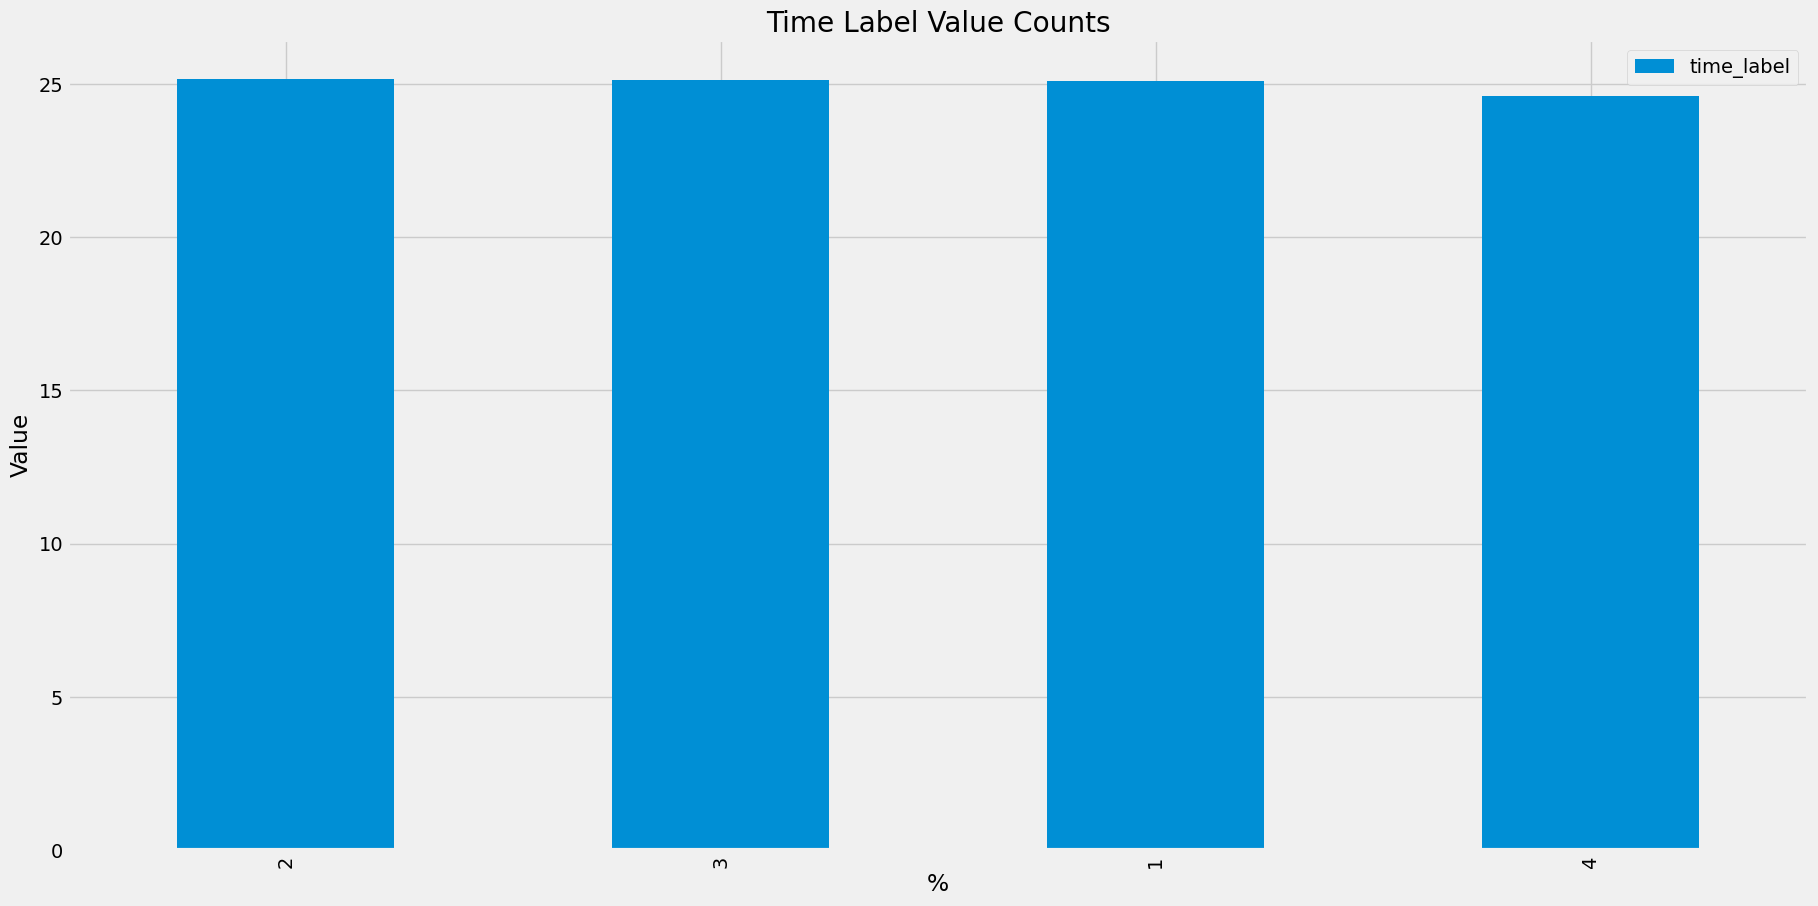

In [34]:
value_counts_plot(bike_rentals, "time_label", "Time Label Value Counts")

3/7
https://community.dataquest.io/t/guided-project-feedback-predicting-bike-rentals/558516
https://community.dataquest.io/t/predicting-bike-rentals-guided-project/525664
https://github.com/dataquestio/solutions/blob/master/Mission213Solution.ipynb